<img src='./img/logoline_12000.png' align='center' width='100%'></img>

# CAMS Air Quality Data Access
In this tutorial we will access and view data from the Copernicus Atmosphere Monitoring Service (CAMS). The tutorial includes the following steps:

[Prepare environment](#prepare)

1. Prepare your environment including registering with the Atmosphere Data Store (ADS) of CAMS, and obtaining an Application Programming Interface (API) key.

[CAMS global atmospheric composition forecasts](#forecast)

2. Download CAMS global atmospheric composition forecasts data for Aerosol Optical Depth (AOD) from ADS.
3. View an animation of forecast data for August 2021.

[CAMS global reanalysis (EAC4) monthly averaged fields](#reanalysis)

4. Download EAC global Carbon Monoxide data for August 2021 at all pressure levels.
5. View animation of CO at different pressure levels.

## <a id='prepare'></a>Prepare environment

Before we begin we must prepare our environment. You will not need to install any software for the training, but if you want to adapt the exercise to your own needs you will need to install the ADS API (`pip install cdsapi`), in addition to Jupyter and Python. You will also need various Python libraries, in particular Xarray http://xarray.pydata.org/en/stable/. Given that most of the Python libraries we will need for this tutorial are included in the Anaconda distribution, if you do wish to set-up your own environment, it is recommended to install Anaconda https://docs.anaconda.com/anaconda/install/.

### Register with ADS

To register with the ADS visit https://ads.atmosphere.copernicus.eu and select **"Login/Register"**

<img src='./img/ADS_login.png' align='left' width='60%'></img>

### Obtain ADS API key

Before you can request data from the ADS, you will need to register on the ADS website and obtain a User ID and API Key. In order to do so, please follow the steps at this link: https://ads.atmosphere.copernicus.eu/api-how-to

Once you have a User ID and API Key for the ADS, insert these into the variables in the cell below. I.e. substitute `ADS_UID` with your ADS User ID and `ADS_API_KEY` with your ADS API key.

In [23]:
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

# enter your ADS authentication key:
ADS_KEY = "ADS_UID:ADS_API_KEY"

### Import libraries

We now need to import the libraries needed for our analyses:

In [3]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Others
from zipfile import ZipFile
from IPython.display import clear_output
from time import sleep

Here we specify a data directory:

In [4]:
DATADIR = './20210930'

## <a id='forecast'></a>CAMS global atmospheric composition forecasts

### Search for data on the ADS

To search for data, visit the ADS website: https://ads.atmosphere.copernicus.eu To facilitate your search you can use keywords, or apply various filters.

The data we are going to use in this part of the exercise is the CAMS global atmospheric composition forecasts data. We are going to download volumetric soil water at layer 1. This parameter is the volume of water in soil layer 1 (0 - 7cm, the surface is at 0cm). We will download data only over the Arctic. We would like to view the anomalies for summer 2019, but the data comes in monthly means. To calculate the anomalies we will subtract from the 2019 data the average of the time series from 1981 to 2010.

Using the filters, or keywords, search for the dataset `CAMS global atmospheric composition forecasts`.

<img src='./img/ADS_result_forecast.png' align='left' width='45%'></img> <img src='./img/ADS_search.png' align='right' width='45%'></img> 

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Variable (Single level): `Organic matter aerosol optical depth at 550nm`
- Date: Start: `2021-08-01`, End: `2021-08-08`
- Time: `00:00` (default)
- Leadtime hour: `0, 6, 12, 18`
- Type: `Forecast` (default)
- Area: Restricted area: `North: 80`, `East: -50`, `South: 25`, `West: -150` 
- Format: `Zipped netCDF (experimental)`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below)...

### Download data using ADS API

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your specified directory.

In [9]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2021-08-01/2021-08-08',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': 'organic_matter_aerosol_optical_depth_550nm',
        'time': '00:00',
        'leadtime_hour': [
            '0', '12', '18',
            '6',
        ],
        'area': [
            80, -150, 25,
            -50,
        ],
    },
    f'{DATADIR}/2021-08_NAmerica_organicMatterAOD.zip')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-08-16 17:14:27,905 INFO Welcome to the CDS
2021-08-16 17:14:27,909 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-08-16 17:14:27,951 INFO Request is queued
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified

Result(content_length=2219756,content_type=application/zip,location=https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data5/adaptor.mars_constrained.internal-1629130472.331898-14316-15-bf208880-3d10-4fda-b4c4-60733dd5484b.zip)

### Read data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for gridded (array-based) scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

First we extract the downloaded zip file:

In [10]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/2021-08_NAmerica_organicMatterAOD.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}/2021-08_NAmerica_organicMatterAOD/')

For convenience, we create a variable with the name of our downloaded file:

In [11]:
fn = f'{DATADIR}/2021-08_NAmerica_organicMatterAOD/data.nc'

Now we can read the data into an Xarray dataset:

In [12]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)

Let's see how this looks by querying our newly created Xarray dataset ...

In [13]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 138, longitude: 251, time: 32)
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-16 16:14:32 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

We see that the dataset has one variable called **"omaod550"**, which stands for "Organic Matter Aerosol Optical Depth at 550nm", and three coordinates of **longitude**, **latitude** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **omaod550** data easier, we convert in into an Xarray data array.

In [15]:
# Create Xarray Data Array
da = ds['omaod550']

In [16]:
da

<xarray.DataArray 'omaod550' (time: 32, latitude: 138, longitude: 251)>
[1108416 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -150.0 -149.6 -149.2 ... -50.8 -50.4 -50.0
  * latitude   (latitude) float32 79.8 79.4 79.0 78.6 ... 26.2 25.8 25.4 25.0
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T18:00:00
Attributes:
    units:      ~
    long_name:  Organic Matter Aerosol Optical Depth at 550nm

To visualise this data we will create an animation, with each frame corresponding to a time step. These include forecasts for each day at lead times of 0, 6, 12 and 18 hours.

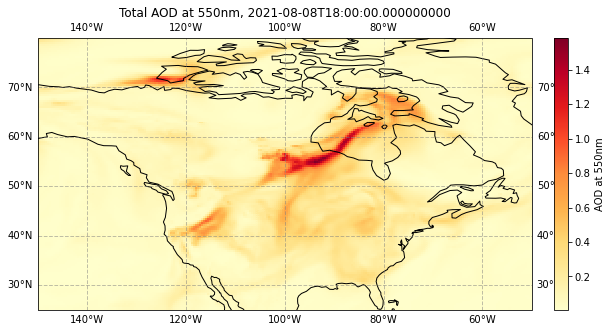

In [22]:
n = 32

for i in range(n):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree())
    ax.coastlines(color='black')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(f'Total AOD at 550nm, {da.time[i].values}', fontsize=12)
    im = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd')
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label('AOD at 550nm')
    plt.show()
    sleep(0.01)
    clear_output(wait=True)

The animation clearly shows the high values of organic matter aerosol optical depth originating from the many different wildfires burning across North America in this period. It also shows these high values crossing the continent to the east coast where it still affects local air quality.

## <a id='reanalysis'></a>CAMS global reanalysis (EAC4) monthly averaged fields

In this part of the tutorial we will look at another CAMS dataset, the fourth generation ECMWF global reanalysis of atmospheric composition (EAC4). Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using a model of the atmosphere based on the laws of physics and chemistry.

We will use the monthly averaged version of this data to analyse the distribution of Carbon Monoxide globally and at different vertical layers in the atmosphere for August 2020.

This dataset is listed in the ADS as `CAMS global reanalysis (EAC4) monthly averaged fields`. Search for this dataset using the filters, or keywords.

The API request below shows the download parameters that we will select:

In [35]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-global-reanalysis-eac4-monthly',
    {
        'variable': 'carbon_monoxide',
        'pressure_level': [
            '1', '2', '3',
            '5', '7', '10',
            '20', '30', '50',
            '70', '100', '150',
            '200', '250', '300',
            '400', '500', '600',
            '700', '800', '850',
            '900', '925', '950',
            '1000',
        ],
        'model_level': '60',
        'year': '2020',
        'month': '08',
        'product_type': 'monthly_mean',
        'format': 'netcdf',
    },
    f'{DATADIR}/EAC4_2020-08_CO.zip')

C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-08-16 12:58:57,904 INFO Welcome to the CDS
2021-08-16 12:58:57,906 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-08-16 12:58:57,941 INFO Request is queued
C:\Users\cxcs\Anaconda3\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS req

Result(content_length=6023882,content_type=application/zip,location=https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data5/adaptor.mars.internal-1629115140.1659167-3153-16-f7011956-e56b-4313-b2ae-f3f7d4fd0ad1.zip)

Extract the file, open it as an Xarray dataset, and inspect the contents:

In [38]:
with ZipFile(f'{DATADIR}/EAC4_2020-08_CO.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/EAC4_2020-08_CO/')

In [109]:
fn = f'{DATADIR}/EAC4_2020-08_CO/levtype_pl.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 25, longitude: 480, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 700 800 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Data variables:
    co         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-16 11:59:00 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [110]:
da = ds['co']
da

<xarray.DataArray 'co' (time: 1, level: 25, latitude: 241, longitude: 480)>
[2892000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 700 800 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

Similar to the above example, we will create an animation, but this time the frames correspond to global distributions of CO at different vertical slices of the atmosphere. Be aware of the changes in scale at each frame!

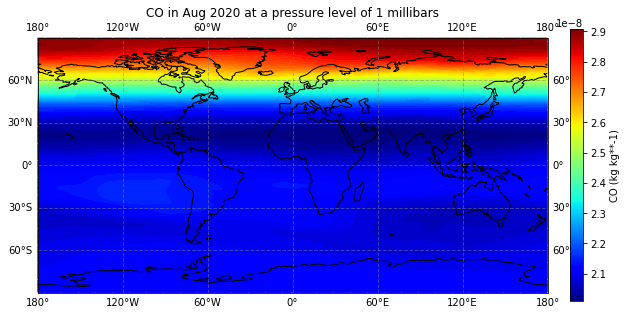

In [114]:
n = 25

for i in range(n):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.coastlines(color='black')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(f'CO in Aug 2020 at a pressure level of {da.level[24-i].values} millibars', fontsize=12)
    im = plt.pcolormesh(da.longitude, da.latitude, da[0,24-i,:,:], cmap='jet')
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label('CO (kg kg**-1)')
    plt.show()
    sleep(0.01)
    clear_output(wait=True)

Notice how the concentration and horizontal distribution of CO varies at different levels of the atmosphere!

### Additional code

In [22]:
# This code is just to create a colour map similar to that used in CAMS products.

matrix = np.array([[256, 256, 256],
                   [210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])
n = 17
cams = np.ones((253, 4))
for i in range(matrix.shape[0]):
    cams[(i*n):((i+1)*n),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])
camscmp = ListedColormap(cams)